In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from termcolor import colored

In [3]:
fpth = 'store-sales-time-series-forecasting/train.csv'
time_column = 'date'
cols_to_drop = ['id']

df = pd.read_csv(fpth, index_col= time_column, parse_dates = True)
if cols_to_drop:
    df = df.drop(cols_to_drop, axis=1)
df.head(3)

,store_nbr,family,sales,onpromotion
date,,,,
2013-01-01,1,AUTOMOTIVE,0.0,0
2013-01-01,1,BABY CARE,0.0,0
2013-01-01,1,BEAUTY,0.0,0


In [7]:
df = df.set_index(['store_nbr', 'family'], append=True)
df.head(3)

sales  onpromotion
date       store_nbr family                        
2013-01-01 1         AUTOMOTIVE    0.0            0
                     BABY CARE     0.0            0
                     BEAUTY        0.0            0

#### Easy - Predicting only average daily sale across all `store_nbr` and all `family` for a given date

In [18]:
average_sales = df.groupby('date').mean()['sales']
average_sales.head(5)

date
2013-01-01      1.409438
2013-01-02    278.390807
2013-01-03    202.840197
2013-01-04    198.911154
2013-01-05    267.873244
Name: sales, dtype: float64

In [25]:
average_sales = average_sales.to_frame()
average_sales.head(5)

,sales
date,
2013-01-01,1.409438
2013-01-02,278.390807
2013-01-03,202.840197
2013-01-04,198.911154
2013-01-05,267.873244


In [28]:
df = average_sales.copy()

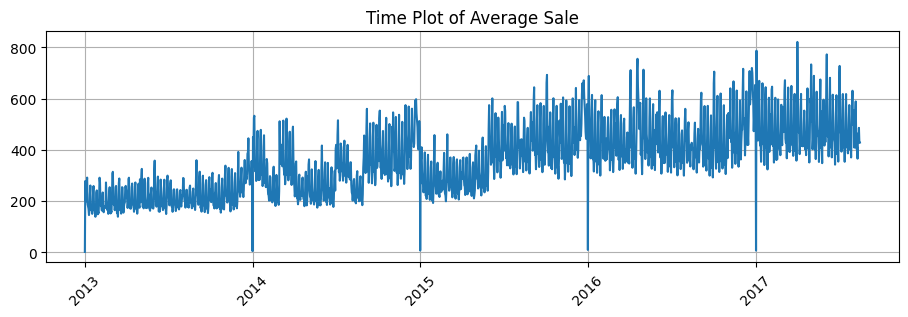

In [36]:
fig, ax = plt.subplots(figsize = (11,3))
ax.plot(df.index, df.sales)
ax.tick_params(axis="x", rotation = 45)
ax.set_title('Time Plot of Average Sale')
ax.grid()

#### Create both Time-step & Lag features 

In [37]:
# # Before creating Time-step & Lag features, check for missing dates, to understand how to create those features
startDate = df.index[0]
endDate = df.index[-1]
print(f'Start date in df: {startDate}\nEnd date in df: {endDate}')

# because we have data for each day, hence, freq = D
possible_dates = pd.date_range(start = startDate, end = endDate, freq='D')
available_dates = df.index

missing_dates = possible_dates.difference(available_dates)
print(f'Total missing dates are : {len(missing_dates)}')
if len(missing_dates)>=1:
    print('Missing dates: ', missing_dates)

Start date in df: 2013-01-01 00:00:00
End date in df: 2017-08-15 00:00:00
Total missing dates are : 4
Missing dates:  DatetimeIndex(['2013-12-25', '2014-12-25', '2015-12-25', '2016-12-25'], dtype='datetime64[ns]', freq=None)


In [38]:
# Time-step feature
# Since no missing dates, we can create Time-step features simply as below
df['Time_dummy'] = np.arange(len(df.index))

# Lag feature
df['Lag_1'] = df['sales'].shift(1)

df.dropna(inplace=True)
df.head(3)

,sales,Time_dummy,Lag_1
date,,,
2013-01-02,278.390807,1,1.409438
2013-01-03,202.840197,2,278.390807
2013-01-04,198.911154,3,202.840197


FOR only_Timestep
X.shape, y.shape:  (1683, 1) (1683,)
Linear Regression score: 0.5153178534364413 
MSE: 8350.176012892762 
sales = 194.69148372385928 + 0.19393825424859462 x Time_dummy



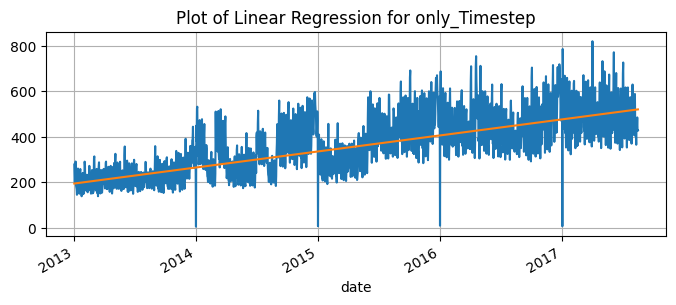

FOR only_Lag
X.shape, y.shape:  (1683, 1) (1683,)
Linear Regression score: 0.5881105908473341 
MSE: 7096.0919205637465 
sales = 84.22310525382778 + 0.76527353254592 x Lag_1



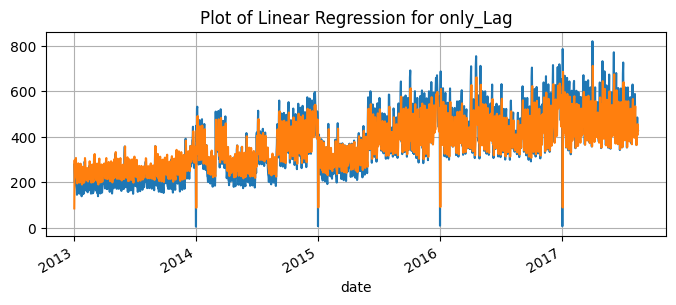

FOR Timestep + Lag
X.shape, y.shape:  (1683, 2) (1683,)
Linear Regression score: 0.6456261124488467 
MSE: 6105.205971388422 
sales = 94.24008675267845 + 0.09316702415632072 x Time_dummy + 0.5179847447173871 x Lag_1



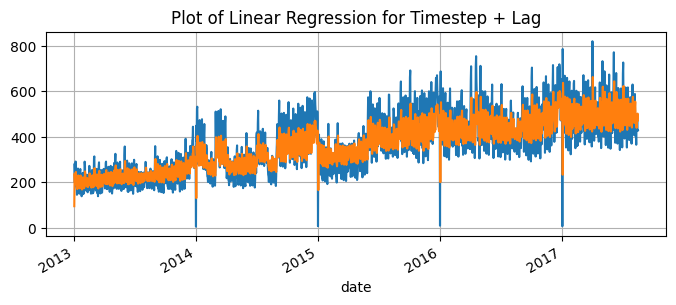

In [39]:
dep = 'sales'
#indeps = ['Time_dummy', 'Lag_1']

indeps_combinations = {
    'only_Timestep': ['Time_dummy'],
    'only_Lag': ['Lag_1'], 
    'Timestep + Lag': ['Time_dummy', 'Lag_1']
}

for case, indeps in indeps_combinations.items():
    print(colored(f'FOR {case}', 'green', attrs=['bold']))
    
    # Fit a linear regression model 
    X = df.loc[:, indeps]
    y = df.loc[:,  dep]
    print('X.shape, y.shape: ', X.shape, y.shape)
    #print('X:\n', X.head(2), '\n\ny: \n', y.head(2))
    
    # Model
    lr = LinearRegression()
    lr.fit(X,y)
    print(colored(f'Linear Regression score: {lr.score(X, y)} ', 'red', attrs=['bold']))
    
    # Predictions
    y_pred = lr.predict(X)
    
    # make preds as a dataframe
    y_pred = pd.Series(y_pred, index = X.index)
    #print('\n\nPredictions:\n', y_pred.head(2))
    print(colored(f'MSE: {mean_squared_error(y, y_pred)} ', 'red', attrs=['bold']))
    
    # Equation
    formula = f'sales = {lr.intercept_}'
    for i in range(len(indeps)):
        formula += f' + {lr.coef_[i]} x {indeps[i]}'
    
    print(colored(formula, 'red', attrs=['bold']))
    print()
    fig, ax = plt.subplots(figsize=(8,3))
    ax = y.plot()
    ax = y_pred.plot()
    ax.set_title(f'Plot of Linear Regression for {case}')
    ax.grid()
    plt.show()

I notice __a large difference in linear regression coefficients for Timestep + Lag case__. It is because scale of both variables are different.

We should use __Scaling__ where all features should have same range

FOR only_Timestep
X.shape, y.shape:  (1683, 1) (1683,)
Linear Regression score: 0.5153178534364413 
MSE: 8350.17601289276 
sales = 357.98749380117596 + 94.22299359153429 x Time_dummy



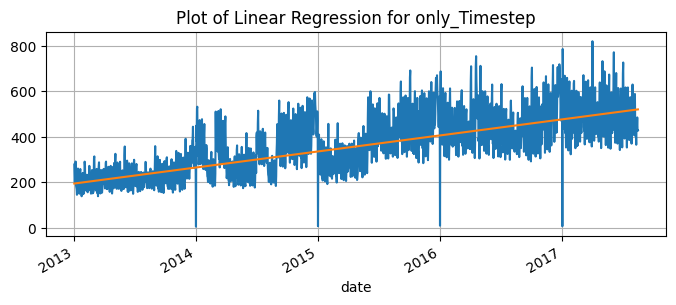

FOR only_Lag
X.shape, y.shape:  (1683, 1) (1683,)
Linear Regression score: 0.5881105908473341 
MSE: 7096.091920563747 
sales = 357.9874938011759 + 100.65811747533985 x Lag_1



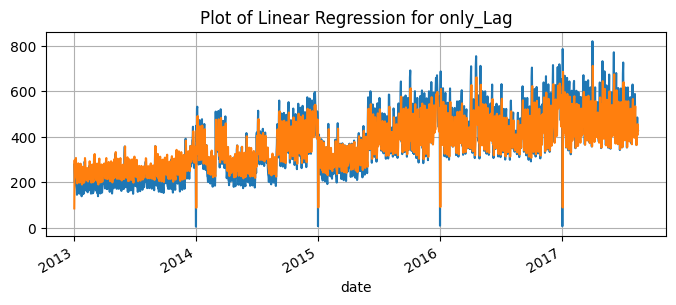

FOR Timestep + Lag
X.shape, y.shape:  (1683, 2) (1683,)
Linear Regression score: 0.6456261124488467 
MSE: 6105.205971388422 
sales = 357.98749380117596 + 45.26428245956502 x Time_dummy + 68.13167719356359 x Lag_1



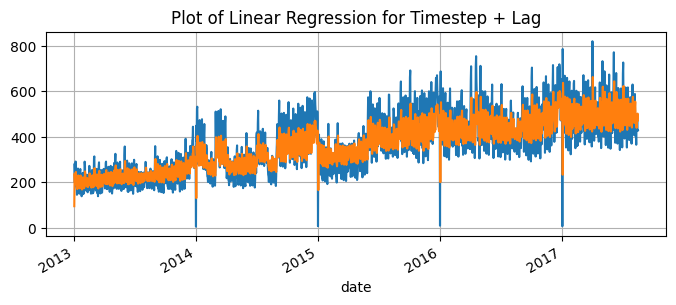

In [40]:
dep = 'sales'
#indeps = ['Time_dummy', 'Lag_1']

indeps_combinations = {
    'only_Timestep': ['Time_dummy'],
    'only_Lag': ['Lag_1'], 
    'Timestep + Lag': ['Time_dummy', 'Lag_1']
}

for case, indeps in indeps_combinations.items():
    print(colored(f'FOR {case}', 'green', attrs=['bold']))
    
    # Fit a linear regression model 
    X = df.loc[:, indeps]
    y = df.loc[:,  dep]
    print('X.shape, y.shape: ', X.shape, y.shape)
    #print('X:\n', X.head(2), '\n\ny: \n', y.head(2))
    scaler = StandardScaler()
    scaler.fit(X)
    X_tr = scaler.transform(X)
    
    # Model
    lr = LinearRegression()
    lr.fit(X_tr,y)
    print(colored(f'Linear Regression score: {lr.score(X_tr, y)} ', 'red', attrs=['bold']))
    
    # Predictions
    y_pred = lr.predict(X_tr)
    
    # make preds as a dataframe
    y_pred = pd.Series(y_pred, index = X.index)
    #print('\n\nPredictions:\n', y_pred.head(2))
    print(colored(f'MSE: {mean_squared_error(y, y_pred)} ', 'red', attrs=['bold']))
    
    # Equation
    formula = f'sales = {lr.intercept_}'
    for i in range(len(indeps)):
        formula += f' + {lr.coef_[i]} x {indeps[i]}'
    
    print(colored(formula, 'red', attrs=['bold']))
    print()
    fig, ax = plt.subplots(figsize=(8,3))
    ax = y.plot()
    ax = y_pred.plot()
    ax.set_title(f'Plot of Linear Regression for {case}')
    ax.grid()
    plt.show()
